# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [124]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [125]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [126]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [150]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=False, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [157]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [158]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

AttributeError: Unable to replace existing score.                                  If you really want to do it use overwrite=True argument

In [159]:
model_artm.seed=1
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [160]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

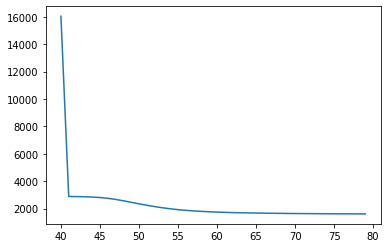

In [161]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value);

Выведем топы слов:

In [162]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=" ")
    tokens = model_artm.score_tracker["top_words"].last_tokens
    if tokens.get(topic_name):
        for word in tokens[topic_name]:    
            print(word, end=" ")
    print()

sbj0:  быть свой год который русский она однако становиться что весь жизнь век время семья после 
sbj1:  быть который город они война время первый древний смочь становиться начинать как армия военный империя 
sbj2:  государство развитие быть год новый такой что происходить общество страна как который первый производство экономический 
sbj3:  x a число b функция тело быть при равный энергия этот уравнение получать что два 
sbj4:  что это они сила мочь для как ребенок друг чтобы который такой так быть когда 
sbj5:  территория страна население этот часть северный являться государство земля природный африка океан регион мир россия 
sbj6:  что свой герой его произведение этот пушкин поэт автор это стихотворение образ любовь весь творчество 
sbj7:  человек который жизнь как общество себя мир литература для личность социальный его свой отношение главный 
sbj8:  который также право это являться весь государственный политика для власть себя мочь государство понятие внутренний 
sbj9:  быть слово

Давайте посмотрим также на разреженность матриц:

In [163]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.6064786911010742
0.0006302521214820445


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [164]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary="dictionary"))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [165]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [166]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=" ")
    tokens = model_artm.score_tracker["top_words"].last_tokens
    if tokens.get(topic_name):
        for word in tokens[topic_name]:    
            print(word, end=" ")
    print()

sbj0:  быть свой русский который она год однако что весь становиться время жизнь они семья после 
sbj1:  быть который война город они время первый год древний смочь становиться военный армия империя начинать 
sbj2:  государство развитие год быть новый такой что общество страна производство происходить который период становиться как 
sbj3:  x a число b функция тело быть при равный этот энергия уравнение получать два точка 
sbj4:  что это они сила как мочь такой друг ребенок для чтобы который так когда очень 
sbj5:  территория страна этот население земля часть являться северный природный африка океан вода регион самый также 
sbj6:  что герой его свой произведение этот пушкин поэт автор это стихотворение образ любовь сам творчество 
sbj7:  человек который жизнь себя как мир общество литература для личность являться его главный век свой 
sbj8:  который также право государство государственный политика это весь являться отношение власть для понятие мочь внутренний 
sbj9:  быть слово предложе

In [167]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8354804515838623
0.002731092507019639


Попробуем менять коэффициент регуляризации:

In [176]:
model_artm.regularizers['SparsePhi'].tau = -50000

In [177]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [178]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=" ")
    tokens = model_artm.score_tracker["top_words"].last_tokens
    if tokens.get(topic_name):
        for word in tokens[topic_name]:    
            print(word, end=" ")
    print()

sbj0:  свой время становиться она русский однако после народ история даже дом семья жить считать I 
sbj1:  первый война начинать город под смочь древний военный благодаря европа появляться конец империя армия житель 
sbj2:  год государство новый развитие период социальный происходить начало уже экономический производство количество проблема мировой путь 
sbj3:  x a если два число вид можно b называть функция пример получать тело равный энергия 
sbj4:  они так мочь сила чтобы когда очень друг ребенок наш сторона несколько часто всегда работа 
sbj5:  страна часть территория земля большой население вода находиться высокий место здесь северный условие природный африка 
sbj6:  его герой самый произведение образ сам пушкин поэт автор писатель рассказ показывать стихотворение тема любовь 
sbj7:  человек жизнь себя общество век главный мир именно каждый более литература многий разный литературный культура 
sbj8:  также представлять россия отношение между право политический процесс форма власть

In [179]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8999316692352295
0.013025210238993168


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [180]:
model_artm.save("my_model")

In [181]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [187]:
phi = model_artm.get_phi() # задать темы и создать модель, после чего загружать

In [188]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
домохозяйка,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000072
институт,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.002413,0.000000
машинка,0.000000,0.0,0.00007,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
прочий,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000504,0.0,0.000000,0.000000
навязнуть,0.000147,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
задабривать,0.000073,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
шаманский,0.000073,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
усопший,0.000073,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
рисование,0.000073,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


Матрица вероятностей тем в документах.

In [184]:
theta = model_artm.get_theta()
theta

,300,301,302,303,304,305,306,307,308,309,...,290,291,292,293,294,295,296,297,298,299
sbj0,0.053435,0.501618,0.037152,0.053333,0.060837,0.011905,0.148368,0.037383,0.101695,0.025455,...,0.159091,0.043796,0.046053,0.131980,0.310843,0.012658,0.019199,0.330986,0.025735,0.068182
sbj1,0.026718,0.090615,0.015480,0.026667,0.022814,0.015873,0.035608,0.023364,0.044068,0.050909,...,0.282468,0.029197,0.039474,0.005076,0.127711,0.016878,0.008772,0.010563,0.014706,0.015152
sbj2,0.034351,0.042071,0.027864,0.015138,0.038023,0.051587,0.094955,0.028037,0.064407,0.509091,...,0.194805,0.025547,0.062500,0.035533,0.231325,0.025316,0.061404,0.042254,0.393382,0.053030
sbj3,0.068702,0.019417,0.114551,0.044444,0.041825,0.119048,0.017804,0.051402,0.037288,0.076364,...,0.019481,0.029197,0.019737,0.020305,0.026506,0.827004,0.039474,0.042254,0.062500,0.102273
sbj4,0.114504,0.139159,0.586899,0.062222,0.140684,0.039683,0.062315,0.056075,0.091525,0.047273,...,0.045455,0.058394,0.055921,0.106599,0.045783,0.025316,0.052632,0.056338,0.088235,0.053030
sbj5,0.003817,0.012945,0.029200,0.542222,0.038023,0.075397,0.148368,0.023364,0.023729,0.043636,...,0.068182,0.025547,0.338816,0.015228,0.012048,0.008439,0.021930,0.021127,0.036765,0.037879
sbj6,0.026718,0.058252,0.018576,0.044444,0.106464,0.027778,0.080119,0.046729,0.277966,0.025455,...,0.019481,0.010949,0.032895,0.548223,0.069880,0.025316,0.030702,0.228873,0.058824,0.037879
sbj7,0.041985,0.093851,0.021672,0.035556,0.471483,0.035714,0.207715,0.067041,0.264407,0.069091,...,0.103896,0.043796,0.111842,0.065990,0.060241,0.008439,0.285088,0.154930,0.033088,0.083333
sbj8,0.580153,0.019417,0.037152,0.162640,0.034221,0.023810,0.068249,0.084112,0.044068,0.036364,...,0.081169,0.689781,0.217105,0.035533,0.067470,0.016878,0.458871,0.066901,0.022059,0.015152
sbj9,0.049618,0.022654,0.111455,0.013333,0.045627,0.599206,0.136499,0.582492,0.050847,0.116364,...,0.025974,0.043796,0.075658,0.035533,0.048193,0.033755,0.021930,0.045775,0.264706,0.534091


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [185]:
theta_test = model_artm.transform(batch_vectorizer)

In [186]:
theta_test

,300,301,302,303,304,305,306,307,308,309,...,290,291,292,293,294,295,296,297,298,299
sbj0,0.053435,0.501618,0.037152,0.053333,0.060837,0.011905,0.148368,0.037383,0.101695,0.025455,...,0.159091,0.043796,0.046053,0.131980,0.310843,0.012658,0.019199,0.330986,0.025735,0.068182
sbj1,0.026718,0.090615,0.015480,0.026667,0.022814,0.015873,0.035608,0.023364,0.044068,0.050909,...,0.282468,0.029197,0.039474,0.005076,0.127711,0.016878,0.008772,0.010563,0.014706,0.015152
sbj2,0.034351,0.042071,0.027864,0.015135,0.038023,0.051587,0.094955,0.028037,0.064407,0.509091,...,0.194805,0.025547,0.062500,0.035533,0.231325,0.025316,0.061404,0.042254,0.393382,0.053030
sbj3,0.068702,0.019417,0.114551,0.044444,0.041825,0.119048,0.017804,0.051402,0.037288,0.076364,...,0.019481,0.029197,0.019737,0.020305,0.026506,0.827004,0.039474,0.042254,0.062500,0.102273
sbj4,0.114504,0.139159,0.586899,0.062222,0.140684,0.039683,0.062315,0.056075,0.091525,0.047273,...,0.045455,0.058394,0.055921,0.106599,0.045783,0.025316,0.052632,0.056338,0.088235,0.053030
sbj5,0.003817,0.012945,0.029200,0.542222,0.038023,0.075397,0.148368,0.023364,0.023729,0.043636,...,0.068182,0.025547,0.338816,0.015228,0.012048,0.008439,0.021930,0.021127,0.036765,0.037879
sbj6,0.026718,0.058252,0.018576,0.044444,0.106464,0.027778,0.080119,0.046729,0.277966,0.025455,...,0.019481,0.010949,0.032895,0.548223,0.069880,0.025316,0.030702,0.228873,0.058824,0.037879
sbj7,0.041985,0.093851,0.021672,0.035556,0.471483,0.035714,0.207715,0.067044,0.264407,0.069091,...,0.103896,0.043796,0.111842,0.065990,0.060241,0.008439,0.285088,0.154930,0.033088,0.083333
sbj8,0.580153,0.019417,0.037152,0.162643,0.034221,0.023810,0.068249,0.084112,0.044068,0.036364,...,0.081169,0.689781,0.217105,0.035533,0.067470,0.016878,0.458871,0.066901,0.022059,0.015152
sbj9,0.049618,0.022654,0.111455,0.013333,0.045627,0.599206,0.136499,0.582489,0.050847,0.116364,...,0.025974,0.043796,0.075658,0.035533,0.048193,0.033755,0.021930,0.045775,0.264706,0.534091
